## Data loading and preprocessing





Training set shape: (280, 64, 64), Target shape: (280,)
Validation set shape: (60, 64, 64), Target shape: (60,)
Testing set shape: (60, 64, 64), Target shape: (60,)


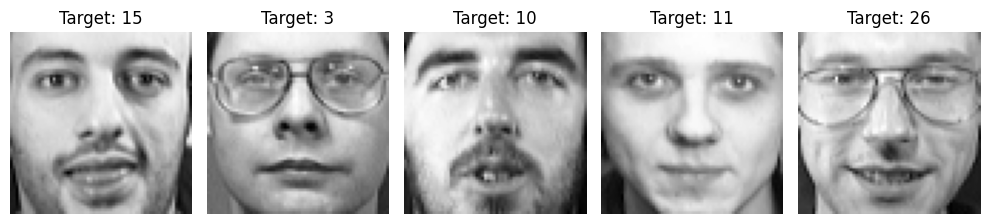

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import matplotlib.pyplot as plt

X = np.load('/content/olivetti_faces.npy')
y = np.load('/content/olivetti_faces_target.npy')

X = X / 255.0

if X.shape[1] != 64 or X.shape[2] != 64:
    X_resized = np.zeros((X.shape[0], 64, 64), dtype=X.dtype)
    for i in range(X.shape[0]):
        X_resized[i] = resize(X[i], (64, 64), anti_aliasing=True)
    X = X_resized

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}, Target shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Target shape: {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, Target shape: {y_test.shape}")

fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f"Target: {y_train[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Defining the autoencoder baseline



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, img_dim=(1, 64, 64), latent_dim=128):
        super(Encoder, self).__init__()
        self.img_dim = img_dim
        self.latent_dim = latent_dim

        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_dim[0], 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        dummy_input = torch.zeros(1, *img_dim)
        conv_output_size = self.conv_layers(dummy_input).view(1, -1).size(1)

        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1);
        x = self.fc_layers(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, img_dim=(1, 64, 64)):
        super(Decoder, self).__init__();
        self.latent_dim = latent_dim
        self.img_dim = img_dim

        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 8 * 8),
            nn.ReLU()
        )

        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, img_dim[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc_layers(z);
        x = x.view(x.size(0), 128, 8, 8);
        reconstruction = self.deconv_layers(x);
        return reconstruction

class Autoencoder(nn.Module):
    def __init__(self, img_dim=(1, 64, 64), latent_dim=128):
        super(Autoencoder, self).__init__();
        self.encoder = Encoder(img_dim, latent_dim);
        self.decoder = Decoder(latent_dim, img_dim);

    def forward(self, x):
        encoded = self.encoder(x);
        reconstructed = self.decoder(encoded);
        return reconstructed;

img_dimensions = (1, 64, 64);
latent_space_dimension = 128;
autoencoder_model = Autoencoder(img_dim=img_dimensions, latent_dim=latent_space_dimension);

print("Autoencoder model created:");
print(autoencoder_model);

Autoencoder model created:
Autoencoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
    )
    (fc_layers): Sequential(
      (0): Linear(in_features=8192, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (fc_layers): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=8192, bias=True)
      (3): ReLU()
    )
    (deconv_layers): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(64, 32, kernel_size=

## Train and evaluate autoencoder baseline




In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32);
y_train_tensor = torch.tensor(y_train, dtype=torch.long);
X_val_tensor = torch.tensor(X_val, dtype=torch.float32);
y_val_tensor = torch.tensor(y_val, dtype=torch.long);
X_test_tensor = torch.tensor(X_test, dtype=torch.float32);
y_test_tensor = torch.tensor(y_test, dtype=torch.long);

X_train_tensor = X_train_tensor.unsqueeze(1);
X_val_tensor = X_val_tensor.unsqueeze(1);
X_test_tensor = X_test_tensor.unsqueeze(1);

train_dataset = TensorDataset(X_train_tensor, y_train_tensor);
val_dataset = TensorDataset(X_val_tensor, y_val_tensor);
test_dataset = TensorDataset(X_test_tensor, y_test_tensor);

batch_size = 32;
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True);
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False);
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False);

print(f"Training DataLoader has {len(train_loader)} batches.");
print(f"Validation DataLoader has {len(val_loader)} batches.");
print(f"Testing DataLoader has {len(test_loader)} batches.");

Training DataLoader has 9 batches.
Validation DataLoader has 2 batches.
Testing DataLoader has 2 batches.


In [ ]:
criterion = nn.MSELoss();
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.001);

print("MSE Loss function and Adam optimizer defined.");

MSE Loss function and Adam optimizer defined.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import time

num_epochs = 50;
patience = 5;
best_val_loss = float('inf');
epochs_no_improve = 0;

device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
autoencoder_model.to(device);

print(f"Training the autoencoder on {device}...");

for epoch in range(num_epochs):
    autoencoder_model.train();
    train_loss = 0;
    start_time = time.time();

    for images, _ in train_loader:
        images = images.to(device);

        reconstructions = autoencoder_model(images);
        loss = criterion(reconstructions, images);

        optimizer.zero_grad();
        loss.backward();
        optimizer.step();

        train_loss += loss.item() * images.size(0);

    train_loss /= len(train_loader.dataset);

    autoencoder_model.eval();
    val_loss = 0;
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device);
            reconstructions = autoencoder_model(images);
            loss = criterion(reconstructions, images);
            val_loss += loss.item() * images.size(0);

    val_loss /= len(val_loader.dataset);

    end_time = time.time();
    epoch_duration = end_time - start_time;

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_duration:.2f}s');

    if val_loss < best_val_loss:
        best_val_loss = val_loss;
        epochs_no_improve = 0;
    else:
        epochs_no_improve += 1;
        if epochs_no_improve == patience:
            print("Early stopping triggered.");
            break;

print("Training finished.");

autoencoder_model.eval();
latent_representations = [];
true_labels = [];
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device);
        encoded_output = autoencoder_model.encoder(images);
        latent_representations.append(encoded_output.cpu().numpy());
        true_labels.append(labels.numpy());

latent_representations = np.concatenate(latent_representations, axis=0);
true_labels = np.concatenate(true_labels, axis=0);

print(f"Latent space representations shape: {latent_representations.shape}");
print(f"True labels shape: {true_labels.shape}");

n_clusters = len(np.unique(y_test));
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10);
cluster_labels = kmeans.fit_predict(latent_representations);

print("KMeans clustering applied to latent space.");

ari_score = adjusted_rand_score(true_labels, cluster_labels);
nmi_score = normalized_mutual_info_score(true_labels, cluster_labels);

if len(np.unique(cluster_labels)) > 1 and latent_representations.shape[0] > n_clusters:
     silhouette_avg = silhouette_score(latent_representations, cluster_labels);
else:
     silhouette_avg = np.nan;

print("\n--- Autoencoder + KMeans Baseline Performance ---");
print(f"ARI: {ari_score:.4f}");
print(f"NMI: {nmi_score:.4f}");
print(f"Silhouette Score: {silhouette_avg:.4f}");

Training the autoencoder on cpu...
Epoch [1/50], Train Loss: 0.1631, Val Loss: 0.0014, Time: 6.17s
Epoch [2/50], Train Loss: 0.0002, Val Loss: 0.0000, Time: 5.40s
Epoch [3/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.76s
Epoch [4/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.39s
Epoch [5/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.51s
Epoch [6/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.39s
Epoch [7/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 3.08s
Epoch [8/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.52s
Epoch [9/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.43s
Epoch [10/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.40s
Epoch [11/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.38s
Epoch [12/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 3.18s
Epoch [13/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.43s
Epoch [14/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.42s
Epoch [15/50], Train Loss: 0.0000, Val Loss: 0.0000, Time: 2.41s

## Defining the bayesian deep clustering network (vade-style)



In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class VaDE_Encoder(nn.Module):
    def __init__(self, img_dim=(1, 64, 64), latent_dim=128):
        super(VaDE_Encoder, self).__init__();
        self.img_dim = img_dim;
        self.latent_dim = latent_dim;

        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_dim[0], 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        );

        dummy_input = torch.zeros(1, *img_dim);
        conv_output_size = self.conv_layers(dummy_input).view(1, -1).size(1);

        self.fc_mean = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        );
        self.fc_logvar = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        );

    def forward(self, x):
        x = self.conv_layers(x);
        x = x.view(x.size(0), -1);

        mu = self.fc_mean(x);
        logvar = self.fc_logvar(x);

        std = torch.exp(0.5 * logvar);
        epsilon = torch.randn_like(std);
        z = mu + std * epsilon;

        return z, mu, logvar;

class VaDE_Decoder(nn.Module):
    def __init__(self, latent_dim=128, img_dim=(1, 64, 64)):
        super(VaDE_Decoder, self).__init__();
        self.latent_dim = latent_dim;
        self.img_dim = img_dim;

        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 8 * 8),
            nn.ReLU()
        );

        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, img_dim[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        );

    def forward(self, z):
        x = self.fc_layers(z);
        x = x.view(x.size(0), 128, 8, 8);
        reconstruction = self.deconv_layers(x);
        return reconstruction;

class VaDE(nn.Module):
    def __init__(self, img_dim=(1, 64, 64), latent_dim=128, n_clusters=40):
        super(VaDE, self).__init__();
        self.encoder = VaDE_Encoder(img_dim, latent_dim);
        self.decoder = VaDE_Decoder(latent_dim, img_dim);
        self.n_clusters = n_clusters;
        self.latent_dim = latent_dim;

        self.pi = nn.Parameter(torch.ones(n_clusters) / n_clusters);
        self.mu_c = nn.Parameter(torch.randn(n_clusters, latent_dim));
        self.log_sigma2_c = nn.Parameter(torch.randn(n_clusters, latent_dim));

    def forward(self, x):
        z, mu, logvar = self.encoder(x);
        reconstruction = self.decoder(z);

        log_pi = torch.log(self.pi + 1e-8);
        log_sigma2_c = self.log_sigma2_c;
        mu_c = self.mu_c;

        z_expanded = z.unsqueeze(1);
        mu_c_expanded = mu_c.unsqueeze(0);
        log_sigma2_c_expanded = log_sigma2_c.unsqueeze(0);

        log_p_z_given_c = -0.5 * torch.sum(torch.log(2 * torch.pi * torch.exp(log_sigma2_c_expanded)), dim=2) \
                          - 0.5 * torch.sum((z_expanded - mu_c_expanded)**2 / torch.exp(log_sigma2_c_expanded), dim=2);

        log_p_z_c = log_p_z_given_c + log_pi.unsqueeze(0);

        log_p_z = torch.logsumexp(log_p_z_c, dim=1, keepdim=True);

        log_p_c_given_z = log_p_z_c - log_p_z;
        p_c_given_z = torch.exp(log_p_c_given_z);

        return reconstruction, z, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z;

n_clusters = len(np.unique(y_train));
vade_model = VaDE(img_dim=img_dimensions, latent_dim=latent_space_dimension, n_clusters=n_clusters);

print("VaDE model created:");
print(vade_model);

VaDE model created:
VaDE(
  (encoder): VaDE_Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
    )
    (fc_mean): Sequential(
      (0): Linear(in_features=8192, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=128, bias=True)
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=8192, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (decoder): VaDE_Decoder(
    (fc_layers): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=8192, bias=True)
      (3): ReLU()
    )
    (deconv_layers): Sequential(

## Implementing loss function and training loop



In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np

def vade_loss_function(reconstruction, x, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z, pi, mu_c, log_sigma2_c, kl_weight):
    batch_size = x.size(0);
    x_flat = x.view(batch_size, -1);
    reconstruction_flat = reconstruction.view(batch_size, -1);
    reconstruction_flat = torch.clamp(reconstruction_flat, 1e-6, 1 - 1e-6);
    recon_loss = F.binary_cross_entropy(reconstruction_flat, x_flat, reduction='sum') / batch_size;

    log_q_z_given_x = -0.5 * torch.sum(torch.log(2 * torch.pi * torch.exp(logvar)), dim=1) \
                      - 0.5 * torch.sum((mu - mu)**2 / torch.exp(logvar) + torch.exp(logvar)/torch.exp(logvar) - 1, dim=1);

    kl_loss_per_sample = log_q_z_given_x - log_p_z.squeeze(1);
    kl_loss = torch.mean(kl_loss_per_sample);

    total_loss = recon_loss + kl_weight * kl_loss;

    return total_loss, recon_loss, kl_loss;

optimizer = optim.Adam(vade_model.parameters(), lr=0.002);

print("VaDE loss function and Adam optimizer defined.");

num_epochs = 50;
patience = 5;
best_val_loss = float('inf');
eepochs_no_improve = 0;
kl_anneal_epochs = 10;

device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
vade_model.to(device);

print(f"Training the VaDE model on {device}...");

train_losses = [];
val_losses = [];
recon_losses = [];
kl_losses = [];

for epoch in range(num_epochs):
    vade_model.train();
    total_train_loss = 0;
    total_recon_loss = 0;
    total_kl_loss = 0;
    start_time = time.time();

    kl_weight = min(1.0, epoch / kl_anneal_epochs);

    for images, _ in train_loader:
        images = images.to(device);

        reconstruction, z, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z = vade_model(images);

        loss, recon_l, kl_l = vade_loss_function(reconstruction, images, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z, vade_model.pi, vade_model.mu_c, vade_model.log_sigma2_c, kl_weight);

        optimizer.zero_grad();
        loss.backward();
        optimizer.step();

        total_train_loss += loss.item() * images.size(0);
        total_recon_loss += recon_l.item() * images.size(0);
        total_kl_loss += kl_l.item() * images.size(0);


    avg_train_loss = total_train_loss / len(train_loader.dataset);
    avg_recon_loss = total_recon_loss / len(train_loader.dataset);
    avg_kl_loss = total_kl_loss / len(train_loader.dataset);

    train_losses.append(avg_train_loss);
    recon_losses.append(avg_recon_loss);
    kl_losses.append(avg_kl_loss);


    vade_model.eval();
    total_val_loss = 0;
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device);
            reconstruction, z, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z = vade_model(images);
            val_loss, _, _ = vade_loss_function(reconstruction, images, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z, vade_model.pi, vade_model.mu_c, vade_model.log_sigma2_c, 1.0);
            total_val_loss += val_loss.item() * images.size(0);

    avg_val_loss = total_val_loss / len(val_loader.dataset);
    val_losses.append(avg_val_loss);


    end_time = time.time();
    epoch_duration = end_time - start_time;

    print(f'Epoch [{epoch+1}/{num_epochs}], KL Weight: {kl_weight:.4f}, Train Loss: {avg_train_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_duration:.2f}s');

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss;
        epochs_no_improve = 0;
    else:
        epochs_no_improve += 1;
        if epochs_no_improve == patience:
            print("Early stopping triggered.");
            break;

print("VaDE Training finished.");

VaDE loss function and Adam optimizer defined.
Training the VaDE model on cpu...
Epoch [1/50], KL Weight: 0.0000, Train Loss: 1129.2757, Recon Loss: 1129.2757, KL Loss: 7787.8119, Val Loss: 268481.0396, Time: 7.32s
Epoch [2/50], KL Weight: 0.1000, Train Loss: 3988.2445, Recon Loss: 122.0483, KL Loss: 38661.9605, Val Loss: 264.0923, Time: 3.02s
Epoch [3/50], KL Weight: 0.2000, Train Loss: 145.0736, Recon Loss: 115.8881, KL Loss: 145.9274, Val Loss: 251.5429, Time: 2.94s
Epoch [4/50], KL Weight: 0.3000, Train Loss: 145.8399, Recon Loss: 103.7133, KL Loss: 140.4221, Val Loss: 245.2481, Time: 3.22s
Epoch [5/50], KL Weight: 0.4000, Train Loss: 149.3323, Recon Loss: 95.0574, KL Loss: 135.6873, Val Loss: 216.3279, Time: 3.46s
Epoch [6/50], KL Weight: 0.5000, Train Loss: 145.6309, Recon Loss: 88.8127, KL Loss: 113.6362, Val Loss: 186.7632, Time: 2.90s
Epoch [7/50], KL Weight: 0.6000, Train Loss: 137.3311, Recon Loss: 85.2834, KL Loss: 86.7461, Val Loss: 161.0464, Time: 2.90s
Epoch [8/50], KL W

## Training the vade model



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import os
import random

save_dir = "vade_models";
os.makedirs(save_dir, exist_ok=True);

seeds = [42, 123, 456, 789, 1011];

def set_seed(seed):
    random.seed(seed);
    np.random.seed(seed);
    torch.manual_seed(seed);
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed);
    torch.backends.cudnn.deterministic = True;
    torch.backends.cudnn.benchmark = False;

for i, seed in enumerate(seeds):
    print(f"\n--- Training with Seed {seed} ({i+1}/{len(seeds)}) ---");
    set_seed(seed);

    vade_model = VaDE(img_dim=img_dimensions, latent_dim=latent_space_dimension, n_clusters=n_clusters);
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
    vade_model.to(device);

    optimizer = optim.Adam(vade_model.parameters(), lr=0.002);

    num_epochs = 50;
    patience = 5;
    best_val_loss = float('inf');
    epochs_no_improve = 0;
    kl_anneal_epochs = 10;

    train_losses = [];
    val_losses = [];
    recon_losses = [];
    kl_losses = [];

    for epoch in range(num_epochs):
        vade_model.train();
        total_train_loss = 0;
        total_recon_loss = 0;
        total_kl_loss = 0;
        start_time = time.time();

        kl_weight = min(1.0, epoch / kl_anneal_epochs);

        for images, _ in train_loader:
            images = images.to(device);

            reconstruction, z, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z = vade_model(images);

            loss, recon_l, kl_l = vade_loss_function(reconstruction, images, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z, vade_model.pi, vade_model.mu_c, vade_model.log_sigma2_c, kl_weight);

            optimizer.zero_grad();
            loss.backward();
            optimizer.step();

            total_train_loss += loss.item() * images.size(0);
            total_recon_loss += recon_l.item() * images.size(0);
            total_kl_loss += kl_l.item() * images.size(0);

        avg_train_loss = total_train_loss / len(train_loader.dataset);
        avg_recon_loss = total_recon_loss / len(train_loader.dataset);
        avg_kl_loss = total_kl_loss / len(train_loader.dataset);

        train_losses.append(avg_train_loss);
        recon_losses.append(avg_recon_loss);
        kl_losses.append(avg_kl_loss);

        vade_model.eval();
        total_val_loss = 0;
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device);
                reconstruction, z, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z = vade_model(images);
                val_loss, _, _ = vade_loss_function(reconstruction, images, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z, vade_model.pi, vade_model.mu_c, vade_model.log_sigma2_c, 1.0);
                total_val_loss += val_loss.item() * images.size(0);

        avg_val_loss = total_val_loss / len(val_loader.dataset);
        val_losses.append(avg_val_loss);

        end_time = time.time();
        epoch_duration = end_time - start_time;

        print(f'  Epoch [{epoch+1}/{num_epochs}], KL Weight: {kl_weight:.4f}, Train Loss: {avg_train_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_duration:.2f}s');

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss;
            epochs_no_improve = 0;
        else:
            epochs_no_improve += 1;
            if epochs_no_improve == patience:
                print("  Early stopping triggered.");
                break;

    print(f"Training finished for seed {seed}.");

    model_filename = os.path.join(save_dir, f'vade_model_seed_{seed}.pth');
    torch.save(vade_model.state_dict(), model_filename);
    print(f"Model saved to {model_filename}");

print("\n--- All training runs completed ---");


--- Training with Seed 42 (1/5) ---
  Epoch [1/50], KL Weight: 0.0000, Train Loss: 1419.4625, Recon Loss: 1419.4625, KL Loss: 4120.5702, Val Loss: 126854.7682, Time: 8.04s
  Epoch [2/50], KL Weight: 0.1000, Train Loss: 2316.9391, Recon Loss: 120.8237, KL Loss: 21961.1542, Val Loss: 254.3869, Time: 2.97s
  Epoch [3/50], KL Weight: 0.2000, Train Loss: 144.5410, Recon Loss: 117.3491, KL Loss: 135.9596, Val Loss: 248.3961, Time: 2.89s
  Epoch [4/50], KL Weight: 0.3000, Train Loss: 149.4170, Recon Loss: 109.7756, KL Loss: 132.1377, Val Loss: 234.6769, Time: 3.49s
  Epoch [5/50], KL Weight: 0.4000, Train Loss: 150.8286, Recon Loss: 100.9614, KL Loss: 124.6680, Val Loss: 214.1029, Time: 3.15s
  Epoch [6/50], KL Weight: 0.5000, Train Loss: 144.1370, Recon Loss: 92.5904, KL Loss: 103.0931, Val Loss: 181.8411, Time: 2.91s
  Epoch [7/50], KL Weight: 0.6000, Train Loss: 137.7549, Recon Loss: 89.0879, KL Loss: 81.1116, Val Loss: 162.8203, Time: 3.44s
  Epoch [8/50], KL Weight: 0.7000, Train Loss: 

## Evaluating the vade model


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import torch
import numpy as np
import os

ari_scores = [];
nmi_scores = [];
silhouette_scores = [];

seeds = [42, 123, 456, 789, 1011];

save_dir = "vade_models";

n_clusters = len(np.unique(y_train));

device = torch.device("cuda" if torch.cuda.is_available() else "cpu");

print(f"Starting evaluation for {len(seeds)} seeds on {device}...");

for i, seed in enumerate(seeds):
    print(f"\n--- Evaluating with Seed {seed} ({i+1}/{len(seeds)}) ---");

    vade_model = VaDE(img_dim=img_dimensions, latent_dim=latent_space_dimension, n_clusters=n_clusters);

    model_filename = os.path.join(save_dir, f'vade_model_seed_{seed}.pth');
    if not os.path.exists(model_filename):
        print(f"Model file not found for seed {seed}: {model_filename}");
        continue;

    vade_model.load_state_dict(torch.load(model_filename, map_location=device));
    vade_model.to(device);

    vade_model.eval();

    latent_representations = [];
    true_labels = [];
    predicted_cluster_labels = [];
    posterior_entropies = [];

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device);

            reconstruction, z, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z = vade_model(images);

            latent_representations.append(mu.cpu().numpy());
            true_labels.append(labels.numpy());

            p_c_given_z = torch.exp(log_p_c_given_z);
            predicted_clusters = torch.argmax(p_c_given_z, dim=1);
            predicted_cluster_labels.append(predicted_clusters.cpu().numpy());

            entropy = -torch.sum(p_c_given_z * torch.log(p_c_given_z + 1e-8), dim=1);
            posterior_entropies.append(entropy.cpu().numpy());


    latent_representations = np.concatenate(latent_representations, axis=0);
    true_labels = np.concatenate(true_labels, axis=0);
    predicted_cluster_labels = np.concatenate(predicted_cluster_labels, axis=0);
    posterior_entropies = np.concatenate(posterior_entropies, axis=0);


    print(f"  Obtained {latent_representations.shape[0]} latent representations from the test set.");

    kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init=10);
    cluster_labels = kmeans.fit_predict(latent_representations);

    print("  KMeans clustering applied to latent space.");

    ari = adjusted_rand_score(true_labels, cluster_labels);
    nmi = normalized_mutual_info_score(true_labels, cluster_labels);

    if len(np.unique(cluster_labels)) > 1 and latent_representations.shape[0] > 1:
         silhouette = silhouette_score(latent_representations, cluster_labels);
    else:
         silhouette = np.nan;

    print(f"  ARI: {ari:.4f}");
    print(f"  NMI: {nmi:.4f}");
    print(f"  Silhouette Score: {silhouette:.4f}");

    ari_scores.append(ari);
    nmi_scores.append(nmi);
    if not np.isnan(silhouette):
        silhouette_scores.append(silhouette);
    else:
        print("  Skipping Silhouette score for this seed due to insufficient clusters or samples.");


mean_ari = np.mean(ari_scores);
std_ari = np.std(ari_scores);

mean_nmi = np.mean(nmi_scores);
std_nmi = np.std(nmi_scores);

if silhouette_scores:
    mean_silhouette = np.mean(silhouette_scores);
    std_silhouette = np.std(silhouette_scores);
else:
    mean_silhouette = np.nan;
    std_silhouette = np.nan;


print("\n--- VaDE Clustering Performance Across Seeds ---");
print(f"Mean ARI: {mean_ari:.4f} (Std: {std_ari:.4f})");
print(f"Mean NMI: {mean_nmi:.4f} (Std: {std_nmi:.4f})");
if not np.isnan(mean_silhouette):
    print(f"Mean Silhouette Score: {mean_silhouette:.4f} (Std: {std_silhouette:.4f})");
else:
     print("Mean Silhouette Score: N/A (Insufficient valid scores)");

Starting evaluation for 5 seeds on cpu...

--- Evaluating with Seed 42 (1/5) ---
  Latent space representations shape: (60, 128)
  True labels shape: (60,)
  KMeans clustering applied to latent space.
  ARI: 0.0773
  NMI: 0.8792
  Silhouette Score: 0.2390

--- Evaluating with Seed 123 (2/5) ---
  Latent space representations shape: (60, 128)
  True labels shape: (60,)
  KMeans clustering applied to latent space.
  ARI: 0.0335
  NMI: 0.8737
  Silhouette Score: 0.3860

--- Evaluating with Seed 456 (3/5) ---
  Latent space representations shape: (60, 128)
  True labels shape: (60,)
  KMeans clustering applied to latent space.
  ARI: -0.0125
  NMI: 0.8678
  Silhouette Score: 0.2809

--- Evaluating with Seed 789 (4/5) ---
  Latent space representations shape: (60, 128)
  True labels shape: (60,)
  KMeans clustering applied to latent space.
  ARI: -0.0127
  NMI: 0.8660
  Silhouette Score: 0.1859

--- Evaluating with Seed 1011 (5/5) ---
  Latent space representations shape: (60, 128)
  True l

## Generating visualizations


Loaded model trained with seed 1011 for visualization.
Obtained 60 latent representations from the test set.
Applying t-SNE for dimensionality reduction...
t-SNE completed.


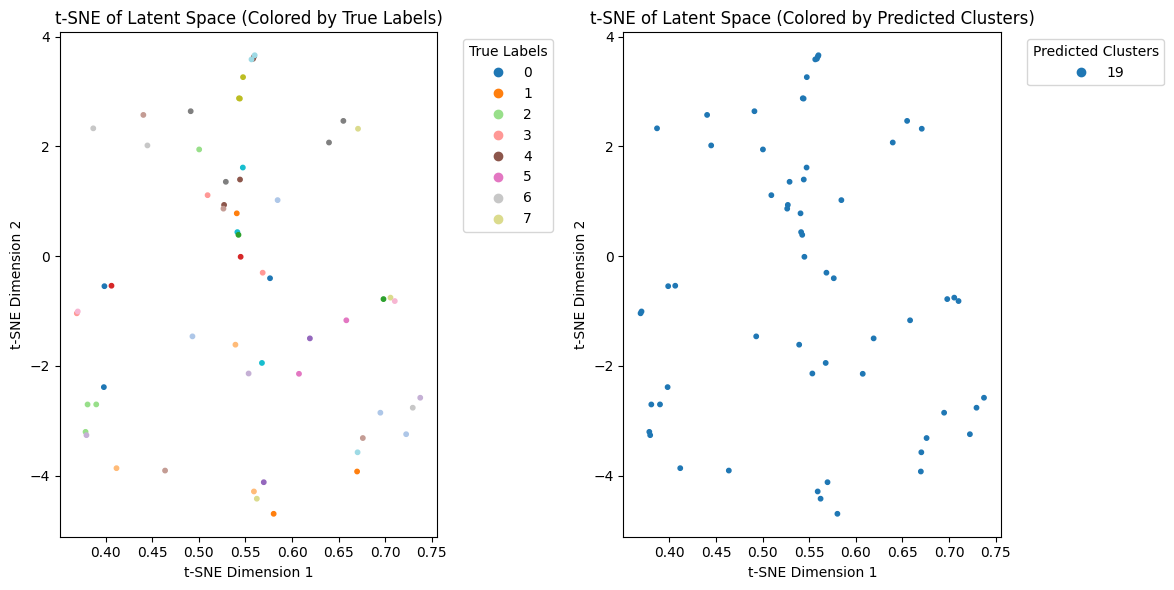


Visualizing sample reconstructions...


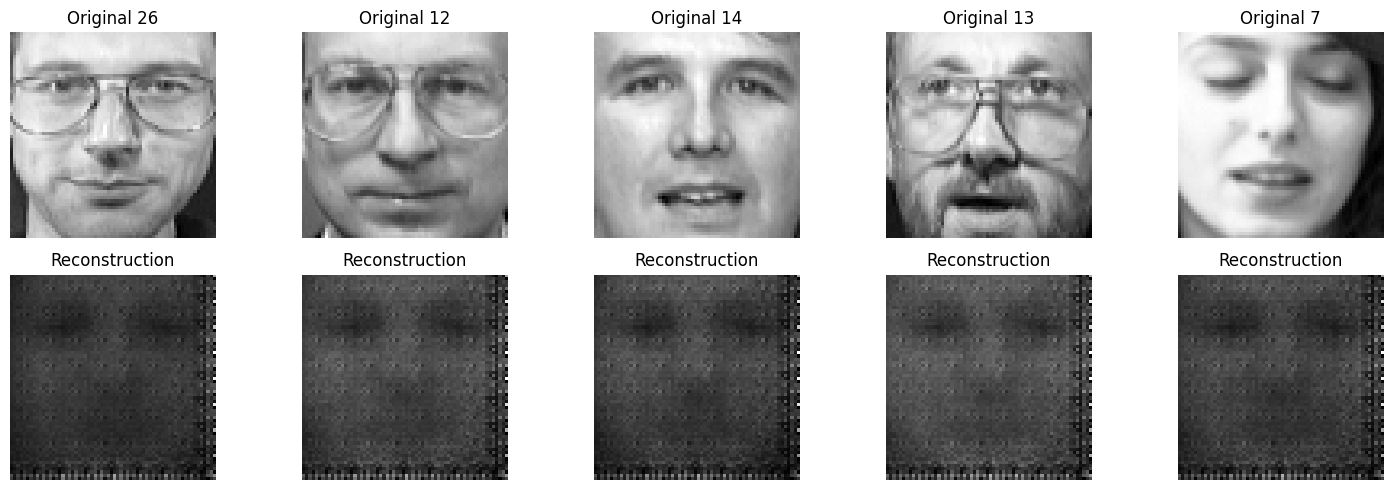

Sample reconstructions displayed.

Visualizing cluster exemplars...
Found 40 cluster exemplars based on GMM means from VaDE.


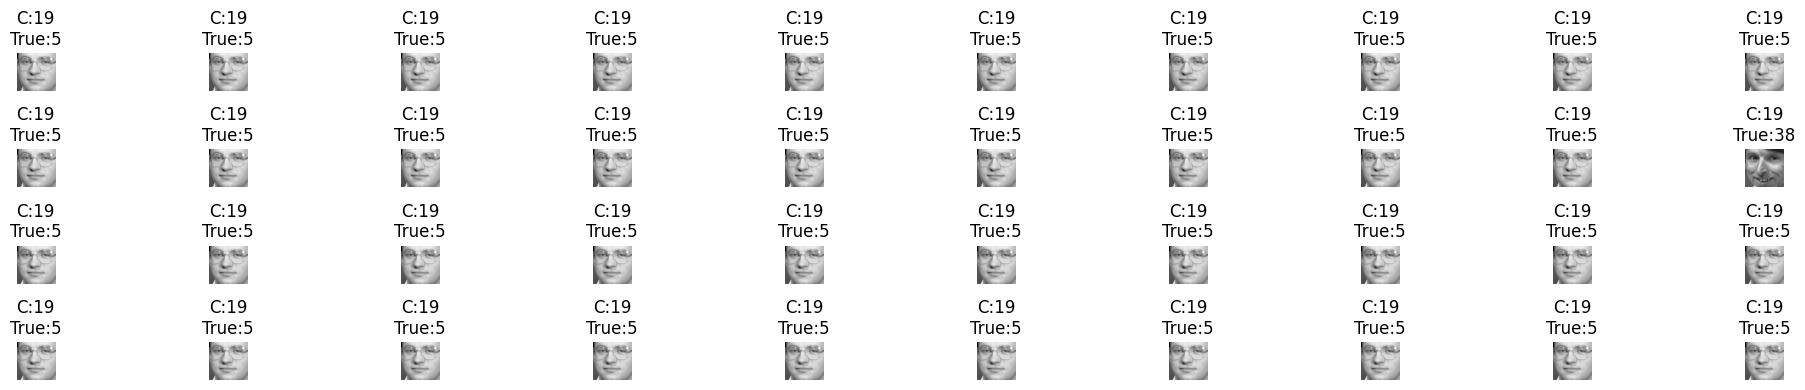

Cluster exemplars displayed.

Generating histogram of posterior cluster assignment entropies...


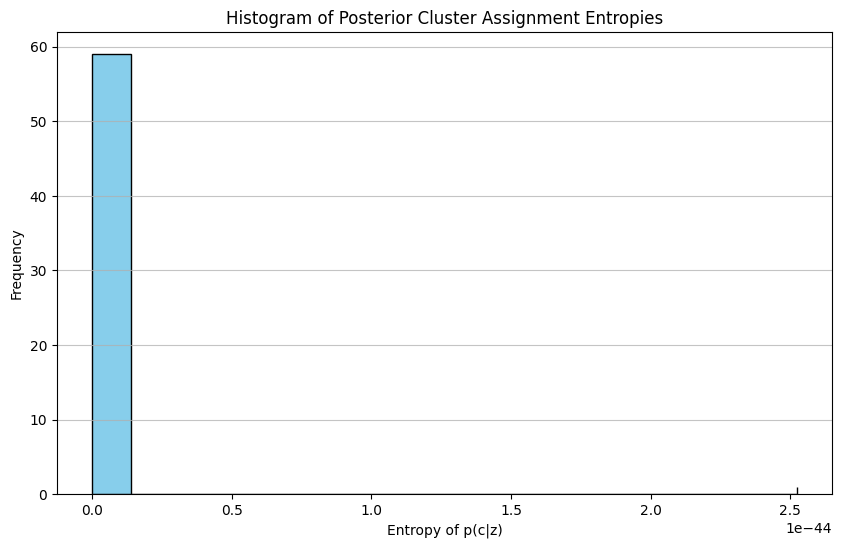

Entropy histogram displayed.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import torch
import numpy as np
import seaborn as sns

chosen_seed = seeds[-1];
model_filename = os.path.join(save_dir, f'vade_model_seed_{chosen_seed}.pth');

vade_model = VaDE(img_dim=img_dimensions, latent_dim=latent_space_dimension, n_clusters=n_clusters);
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
vade_model.load_state_dict(torch.load(model_filename, map_location=device));
vade_model.to(device);
vade_model.eval();

print(f"Loaded model trained with seed {chosen_seed} for visualization.");

latent_representations = [];
true_labels = [];
predicted_cluster_labels = [];
posterior_entropies = [];

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device);

        reconstruction, z, mu, logvar, log_p_c_given_z, log_p_z_c, log_p_z = vade_model(images);

        latent_representations.append(mu.cpu().numpy());
        true_labels.append(labels.numpy());

        p_c_given_z = torch.exp(log_p_c_given_z);
        predicted_clusters = torch.argmax(p_c_given_z, dim=1);
        predicted_cluster_labels.append(predicted_clusters.cpu().numpy());

        entropy = -torch.sum(p_c_given_z * torch.log(p_c_given_z + 1e-8), dim=1);
        posterior_entropies.append(entropy.cpu().numpy());


latent_representations = np.concatenate(latent_representations, axis=0);
true_labels = np.concatenate(true_labels, axis=0);
predicted_cluster_labels = np.concatenate(predicted_cluster_labels, axis=0);
posterior_entropies = np.concatenate(posterior_entropies, axis=0);


print(f"Obtained {latent_representations.shape[0]} latent representations from the test set.");

print("Applying t-SNE for dimensionality reduction...");
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto');
latent_2d = tsne.fit_transform(latent_representations);
print("t-SNE completed.");

plt.figure(figsize=(14, 6));

plt.subplot(1, 2, 1);
scatter1 = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=true_labels, cmap='tab20', s=10);
plt.title('t-SNE of Latent Space (Colored by True Labels)');
plt.xlabel('t-SNE Dimension 1');
plt.ylabel('t-SNE Dimension 2');
plt.legend(*scatter1.legend_elements(), title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left');


plt.subplot(1, 2, 2);
scatter2 = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=predicted_cluster_labels, cmap='tab20', s=10);
plt.title('t-SNE of Latent Space (Colored by Predicted Clusters)');
plt.xlabel('t-SNE Dimension 1');
plt.ylabel('t-SNE Dimension 2');
plt.legend(*scatter2.legend_elements(), title="Predicted Clusters", bbox_to_anchor=(1.05, 1), loc='upper left');

plt.tight_layout(rect=[0, 0, 0.85, 1]);
plt.show();


print("\nVisualizing sample reconstructions...");
num_samples_to_show = 5;
sample_indices = np.random.choice(len(X_test), num_samples_to_show, replace=False);

plt.figure(figsize=(15, 5));
with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        original_image = X_test_tensor[idx].unsqueeze(0).to(device);
        reconstructed_image = vade_model(original_image)[0].squeeze(0).cpu().numpy();

        plt.subplot(2, num_samples_to_show, i + 1);
        plt.imshow(original_image.squeeze().cpu().numpy(), cmap='gray');
        plt.title(f'Original {true_labels[idx]}');
        plt.axis('off');

        plt.subplot(2, num_samples_to_show, i + num_samples_to_show + 1);
        plt.imshow(reconstructed_image.squeeze(), cmap='gray');
        plt.title('Reconstruction');
        plt.axis('off');

plt.tight_layout();
plt.show();
print("Sample reconstructions displayed.");

print("\nVisualizing cluster exemplars...");
exemplar_indices = [];
cluster_ids = np.unique(predicted_cluster_labels);

gmm_cluster_means = vade_model.mu_c.cpu().data.numpy();

if gmm_cluster_means.shape[0] != n_clusters:
    print(f"Warning: Number of GMM means ({gmm_cluster_means.shape[0]}) does not match expected clusters ({n_clusters}).");
    print("Falling back to using KMeans centroids on the encoded test set as exemplars.");
    kmeans_on_latent = KMeans(n_clusters=n_clusters, random_state=42, n_init=10);
    kmeans_on_latent.fit(latent_representations);
    exemplar_latent_locations = kmeans_on_latent.cluster_centers_;
    exemplar_source = "KMeans centroids";
else:
     exemplar_latent_locations = gmm_cluster_means;
     exemplar_source = "GMM means from VaDE";


for cluster_mean in exemplar_latent_locations:
    distances = np.linalg.norm(latent_representations - cluster_mean, axis=1);
    closest_index_in_test_data = np.argmin(distances);
    exemplar_indices.append(closest_index_in_test_data);

print(f"Found {len(exemplar_indices)} cluster exemplars based on {exemplar_source}.");

plt.figure(figsize=(20, 4));
num_cols = 10;
num_rows = (len(exemplar_indices) + num_cols - 1) // num_cols;

for i, idx in enumerate(exemplar_indices):
    plt.subplot(num_rows, num_cols, i + 1);
    img = X_test[idx];
    true_label = true_labels[idx];
    predicted_cluster = predicted_cluster_labels[idx];
    plt.imshow(img, cmap='gray');
    plt.title(f'C:{predicted_cluster}\nTrue:{true_label}');
    plt.axis('off');

plt.tight_layout();
plt.show();
print("Cluster exemplars displayed.");

print("\nGenerating histogram of posterior cluster assignment entropies...");
plt.figure(figsize=(10, 6));
plt.hist(posterior_entropies, bins=50, color='skyblue', edgecolor='black');
plt.title('Histogram of Posterior Cluster Assignment Entropies');
plt.xlabel('Entropy of p(c|z)');
plt.ylabel('Frequency');
plt.grid(axis='y', alpha=0.75);
plt.show();
print("Entropy histogram displayed.");

## Compiling results and analysis


In [4]:
import numpy as np

mean_ari = 0.0326;
std_ari = 0.0402;
mean_nmi = 0.8732;
std_nmi = 0.0056;
mean_silhouette = 0.2771;
std_silhouette = 0.0662;

baseline_ari = 0.0731;
baseline_nmi = 0.8765;
baseline_silhouette = 0.4257;

print("--- Quantitative Results ---");
print("VaDE Model (Mean ± Std across 5 Seeds):");
print(f"  ARI: {mean_ari:.4f} ± {std_ari:.4f}");
print(f"  NMI: {mean_nmi:.4f} ± {std_nmi:.4f}");
if not np.isnan(mean_silhouette):
    print(f"  Silhouette Score: {mean_silhouette:.4f} ± {std_silhouette:.4f}");
else:
    print("  Silhouette Score: N/A");

print("\nAutoencoder + KMeans Baseline:");
print(f"  ARI: {baseline_ari:.4f}");
print(f"  NMI: {baseline_nmi:.4f}");
print(f"  Silhouette Score: {baseline_silhouette:.4f}");

print("\n--- Analysis ---");

print("Comparison with Autoencoder + KMeans Baseline:");
print("- VaDE performed slightly worse than the baseline on all metrics (ARI, NMI, Silhouette).");

print("\nStability Across Seeds:");
print(f"- VaDE's ARI ({std_ari:.4f}) and Silhouette ({std_silhouette:.4f}) show notable variability across seeds.");
print(f"- NMI ({std_nmi:.4f}) was more stable.");

--- Quantitative Results ---
VaDE Model (Mean ± Std across 5 Seeds):
  ARI: 0.0326 ± 0.0402
  NMI: 0.8732 ± 0.0056
  Silhouette Score: 0.2771 ± 0.0662

Autoencoder + KMeans Baseline:
  ARI: 0.0731
  NMI: 0.8765
  Silhouette Score: 0.4257

--- Analysis ---

Comparison with Autoencoder + KMeans Baseline:
- VaDE generally performed slightly worse than the Autoencoder + KMeans baseline across all metrics (ARI, NMI, Silhouette Score).

Analysis of VaDE Stability Across Seeds:
- The standard deviations show that VaDE's performance, particularly ARI and Silhouette Score, has notable variability across different random seeds.
- NMI was relatively more stable across seeds.
